## Estudo e Comparação de Técnicas de Compressão de Imagens Baseadas em Transformadas Discretas

## **Interface interativa e educativa para compressão de imagens utilizando a DCT**

#### Adinan Alves de Brito Filho e Kenji Nose Filho

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import random

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from skimage.color import rgb2yuv, yuv2rgb
import skimage.measure
from skimage.feature import greycomatrix
import sewar

import ipywidgets as widgets
from IPython.display import clear_output

from pathlib import Path
from google.colab import drive, files

Faça o upload do dataset para o diretório raiz do seu drive. 

Em seguida, permita o acesso do Collab ao seu drive, para adicionar as imagens à interface.

In [4]:
# Diretório da pasta do dataset
DIR = './dataset/'

## Tabelas de quantização

In [5]:
matriz_luminancia_JPEG = ([16,11,10,16,24,40,51,61],
                     [12,12,14,19,26,58,60,55],
                     [14,13,16,24,40,57,69,56],
                     [14,17,22,29,51,87,80,62],
                     [18,22,37,56,68,109,103,77],
                     [24,35,55,64,81,104,113,92],
                     [49,64,78,87,103,121,120,101],
                     [72,92,95,98,112,100,103,99],)
matriz_luminancia_JPEG = np.asarray(matriz_luminancia_JPEG)

matriz_crominancia_JPEG = ([17,18,24,47,99,99,99,99],
                      [18,21,26,66,99,99,99,99],
                      [24,26,56,99,99,99,99,99],
                      [47,66,99,99,99,99,99,99],
                      [99,99,99,99,99,99,99,99],
                      [99,99,99,99,99,99,99,99],
                      [99,99,99,99,99,99,99,99],
                      [99,99,99,99,99,99,99,99])
matriz_crominancia_JPEG = np.asarray(matriz_crominancia_JPEG)

matriz_lum_kendinan = ([4,9,16,25,36,49,64,81],
                       [9,16,25,36,49,64,81,99],
                       [16,25,36,49,64,81,99,99],
                       [25,36,49,64,81,99,99,99],
                       [36,49,64,81,99,99,99,99],
                       [49,64,81,99,99,99,99,99],
                       [64,81,99,99,99,99,99,99],
                       [81,99,99,99,99,99,99,99])
matriz_lum_kendinan = np.asarray(matriz_lum_kendinan)

matriz_cro_kendinan = ([6,16,32,56,89,99,99,99],
                       [16,32,56,89,99,99,99,99],
                       [32,56,89,99,99,99,99,99],
                       [56,89,99,99,99,99,99,99],
                       [89,99,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99])
matriz_cro_kendinan = np.asarray(matriz_cro_kendinan)

## Tratamento e processamento da imagem

In [6]:
qtd_imagens = (len([name for name in os.listdir(DIR) 
                    if os.path.isfile(os.path.join(DIR, name))]))

def resize(path):
    dirs = os.listdir(path)
    cont = 11
    for item in dirs:      
        if os.path.isfile(path+item):
            image = Image.open(path+item)
            image = image.resize((600,400),Image.ANTIALIAS)
            image.save(fp=(DIR+str(cont)+'.png'))
            cont += 1

def resize(path):
    dirs = os.listdir(path)
    cont = 11
    for item in dirs:      
        if os.path.isfile(path+item):
            image = Image.open(path+item)
            image = image.resize((600,400),Image.ANTIALIAS)
            image.save(fp=('novodataset/'+str(cont)+'.png'))
            cont += 1

            
def RGBtoYCbCr(imagem_escolhida_RGB_array):
    
    l, c, d = imagem_escolhida_RGB_array.shape
    Y = np.zeros((l,c))
    Cb = np.zeros((l,c))
    Cr = np.zeros((l,c))
    
    Y = ((0.299*imagem_escolhida_RGB_array[:,:,0])
         + (0.587*imagem_escolhida_RGB_array[:,:,1])
         + (0.114*imagem_escolhida_RGB_array[:,:,2]))

    Cb = ((-0.1687*imagem_escolhida_RGB_array[:,:,0])
          + (-0.3313*imagem_escolhida_RGB_array[:,:,1])
          + (0.5*imagem_escolhida_RGB_array[:,:,2])
          + 128)

    Cr = ((0.5*imagem_escolhida_RGB_array[:,:,0]) 
          + (-0.4187*imagem_escolhida_RGB_array[:,:,1])
          + (-0.0813*imagem_escolhida_RGB_array[:,:,2])
          + 128)
    
    Y = np.around(Y,0)
    Y = np.asarray(Y, dtype = int)

    Cb = np.around(Cb,0)
    Cb = np.asarray(Cb, dtype = int)

    Cr = np.around(Cr,0)
    Cr = np.asarray(Cr, dtype = int)
    
    return Y, Cb, Cr


def YCbCrtoRGB(imagem_YCbCr_array):
    
    l, c, d = imagem_YCbCr_array.shape
    img = np.zeros((l,c,3))
         
    img[:,:,0] = ((imagem_YCbCr_array[:,:,0])
                  + (1.402*(imagem_YCbCr_array[:,:,2] - 128)))

    img[:,:,1] = ((imagem_YCbCr_array[:,:,0]) 
                  - (0.34414*(imagem_YCbCr_array[:,:,1] - 128))
                  - (0.71414*(imagem_YCbCr_array[:,:,2] - 128)))
    
    img[:,:,2] = ((imagem_YCbCr_array[:,:,0]) 
                  + (1.772*(imagem_YCbCr_array[:,:,1] - 128)))
    
    img = np.around(img,0)
    img = img.astype(int)
    
    return img


def particionamento(matriz_0, matriz_1, matriz_2):
    
    l, c = matriz_0.shape
    part_0 = np.zeros((l//8, c//8, 8, 8))
    part_1 = np.zeros((l//8, c//8, 8, 8))
    part_2 = np.zeros((l//8, c//8, 8, 8))
    
    for x in range(l//8):
        for y in range(c//8):
            for r in range(8):
                for s in range(8):
                    part_0[x,y,r,s] = matriz_0[x*8+r, y*8+s]
                    part_1[x,y,r,s] = matriz_1[x*8+r, y*8+s]
                    part_2[x,y,r,s] = matriz_2[x*8+r, y*8+s]
                    
    return part_0, part_1, part_2


def uniao_submatrizes(matriz0, matriz1, matriz2):   
    
    l, c, x, y = matriz0.shape
    matriz_completa_0 = np.zeros((l*8,c*8))
    matriz_completa_1 = np.zeros((l*8,c*8))
    matriz_completa_2 = np.zeros((l*8,c*8))
    
    for i in range(l):
        for j in range(c):
            for k in range (x):
                for m in range(y):
                    matriz_completa_0[i*8+k, j*8+m] = matriz0[i,j,k,m]
                    matriz_completa_1[i*8+k, j*8+m] = matriz1[i,j,k,m]
                    matriz_completa_2[i*8+k, j*8+m] = matriz2[i,j,k,m]
                 
    return matriz_completa_0, matriz_completa_1, matriz_completa_2


def dct(matriz0, matriz1, matriz2):
    
    l, c, pix1, pix2 = matriz0.shape
    dct_0 = np.zeros((l,c,8,8))
    dct_1 = np.zeros((l,c,8,8))
    dct_2 = np.zeros((l,c,8,8))
    
    dct_0_antes = np.zeros((l,c,8,8))
    dct_1_antes = np.zeros((l,c,8,8))
    dct_2_antes = np.zeros((l,c,8,8))
    
    for i in range(l):
        for j in range(c):
            dct_0[i,j,:,:] = cv2.dct(matriz0[i,j,:,:])
            dct_1[i,j,:,:] = cv2.dct(matriz1[i,j,:,:])
            dct_2[i,j,:,:] = cv2.dct(matriz2[i,j,:,:])
            
            dct_0_antes[i,j,:,:] = dct_0[i,j,:,:]
            dct_1_antes[i,j,:,:] = dct_1[i,j,:,:]
            dct_2_antes[i,j,:,:] = dct_2[i,j,:,:]
            
            if mascaramento.value == 'Máscara Triangular':
                
                if (btn_taxa_DCT.value == 'Baixo (39%)'):
                    dct_0[i,j,5:8,4:8] = 0;
                    dct_0[i,j,2:5,6:8] = 0;
                    dct_0[i,j,6:8,2:4] = 0;
                    dct_0[i,j,7,1] = 0;
                    dct_0[i,j,4,5] = 0;
                    dct_0[i,j,1,7] = 0;
                    
                    dct_1[i,j,5:8,4:8] = 0;
                    dct_1[i,j,2:5,6:8] = 0;
                    dct_1[i,j,6:8,2:4] = 0;
                    dct_1[i,j,7,1] = 0;
                    dct_1[i,j,4,5] = 0;
                    dct_1[i,j,1,7] = 0;
                    
                    dct_2[i,j,5:8,4:8] = 0;
                    dct_2[i,j,2:5,6:8] = 0;
                    dct_2[i,j,6:8,2:4] = 0;
                    dct_2[i,j,7,1] = 0;
                    dct_2[i,j,4,5] = 0;
                    dct_2[i,j,1,7] = 0;
                    
                elif (btn_taxa_DCT.value == 'Intermediário (56%)'):
                    for linha in range(8):
                        for coluna in range(8):
                            if((linha + coluna) >= 7):
                                dct_0[i,j,linha,coluna] = 0;
                                dct_1[i,j,linha,coluna] = 0;
                                dct_2[i,j,linha,coluna] = 0;
                    
                elif (btn_taxa_DCT.value == 'Alto (77%)'):
                    for linha in range(8):
                        for coluna in range(8):
                            if((linha + coluna) >= 5):
                                dct_0[i,j,linha,coluna] = 0;
                                dct_1[i,j,linha,coluna] = 0;
                                dct_2[i,j,linha,coluna] = 0;
                    
                else:
                    for linha in range(8):
                        for coluna in range(8):
                            if((linha + coluna) >= 3):
                                dct_0[i,j,linha,coluna] = 0;
                                dct_1[i,j,linha,coluna] = 0;
                                dct_2[i,j,linha,coluna] = 0;
                    
            else:
                if (btn_taxa_DCT.value == 'Baixo (39%)'):
                    dct_0[i,j,3:8,3:8] = 0;
                    dct_1[i,j,3:8,3:8] = 0; 
                    dct_2[i,j,3:8,3:8] = 0;
                elif (btn_taxa_DCT.value == 'Intermediário (56%)'):
                    dct_0[i,j,2:8,2:8] = 0;
                    dct_1[i,j,2:8,2:8] = 0;
                    dct_2[i,j,2:8,2:8] = 0;
                elif (btn_taxa_DCT.value == 'Alto (77%)'):
                    dct_0[i,j,1:8,1:8] = 0;
                    dct_1[i,j,1:8,1:8] = 0;
                    dct_2[i,j,1:8,1:8] = 0;
                else:
                    dct_0[i,j,1:8,1:8] = 0;
                    dct_0[i,j,0,4:8] = 0;
                    dct_0[i,j,4:8,0] = 0;
                    dct_1[i,j,1:8,1:8] = 0;
                    dct_1[i,j,0,4:8] = 0;
                    dct_1[i,j,4:8,0] = 0;
                    dct_2[i,j,1:8,1:8] = 0;
                    dct_2[i,j,0,4:8] = 0;
                    dct_2[i,j,4:8,0] = 0;
            
    dct_0 = np.around(dct_0,0)
    dct_1 = np.around(dct_1,0)
    dct_2 = np.around(dct_2,0)
    
    dct_0_antes = np.around(dct_0_antes,0)
    dct_1_antes = np.around(dct_1_antes,0)
    dct_2_antes = np.around(dct_2_antes,0)
            
    return dct_0, dct_1, dct_2, dct_0_antes, dct_1_antes, dct_2_antes


def dct_tabelas(matriz0, matriz1, matriz2):
    fator = float(btn_fator_compressao.value)
    l, c, pix1, pix2 = matriz0.shape
    dct_0 = np.zeros((l,c,8,8))
    dct_1 = np.zeros((l,c,8,8))
    dct_2 = np.zeros((l,c,8,8))
    
    for i in range(l):
        for j in range(c):
            dct_0[i,j,:,:] = cv2.dct(matriz0[i,j,:,:])
            dct_1[i,j,:,:] = cv2.dct(matriz1[i,j,:,:])
            dct_2[i,j,:,:] = cv2.dct(matriz2[i,j,:,:])
            
            if (tipo_tabela.value=='Tabela JPEG Standard'):
                dct_0[i,j,:,:] = (dct_0[i,j,:,:])/(fator*matriz_luminancia_JPEG)
                dct_1[i,j,:,:] = (dct_1[i,j,:,:])/(fator*matriz_crominancia_JPEG)
                dct_2[i,j,:,:] = (dct_2[i,j,:,:])/(fator*matriz_crominancia_JPEG)
            else:
                dct_0[i,j,:,:] = (dct_0[i,j,:,:])/(fator*matriz_lum_kendinan)
                dct_1[i,j,:,:] = (dct_1[i,j,:,:])/(fator*matriz_cro_kendinan)
                dct_2[i,j,:,:] = (dct_2[i,j,:,:])/(fator*matriz_cro_kendinan)
            
    dct_0 = np.asarray(np.around(dct_0,0))
    dct_1 = np.asarray(np.around(dct_1,0))
    dct_2 = np.asarray(np.around(dct_2,0))
    
    return dct_0, dct_1, dct_2


def dct_completa(matriz0, matriz1, matriz2):
    l, c, pix1, pix2 = matriz0.shape
    dct_0 = np.zeros((l,c,8,8))
    dct_1 = np.zeros((l,c,8,8))
    dct_2 = np.zeros((l,c,8,8))
    
    for i in range(l):
        for j in range(c):
            dct_0[i,j,:,:] = cv2.dct(matriz0[i,j,:,:])
            dct_1[i,j,:,:] = cv2.dct(matriz1[i,j,:,:])
            dct_2[i,j,:,:] = cv2.dct(matriz2[i,j,:,:])
            
    dct_0 = np.around(dct_0,0)
    dct_1 = np.around(dct_1,0)
    dct_2 = np.around(dct_2,0)
    
    return dct_0, dct_1, dct_2


def idct(dct_0, dct_1, dct_2):
    
    l = len(dct_0)
    c = len(dct_0[0])
    idct_0 = np.zeros((l,c,8,8))
    idct_1 = np.zeros((l,c,8,8))
    idct_2 = np.zeros((l,c,8,8))
    
    for i in range(l):
        for j in range(c):
            idct_0[i,j,:,:] = cv2.idct(dct_0[i,j,:,:])
            idct_1[i,j,:,:] = cv2.idct(dct_1[i,j,:,:])
            idct_2[i,j,:,:] = cv2.idct(dct_2[i,j,:,:])
            
    idct_0 = np.around(idct_0,0)
    idct_1 = np.around(idct_1,0)
    idct_2 = np.around(idct_2,0)
            
    return idct_0, idct_1, idct_2

def idct_tabelas(dct_0, dct_1, dct_2):
    fator = float(btn_fator_compressao.value)
    l = len(dct_0)
    c = len(dct_0[0])
    idct_0 = np.zeros((l,c,8,8))
    idct_1 = np.zeros((l,c,8,8))
    idct_2 = np.zeros((l,c,8,8))
    
    for i in range(l):
        for j in range(c):
            
            if (tipo_tabela.value=='Tabela JPEG Standard'):
                idct_0[i,j,:,:] = (dct_0[i,j,:,:]*(fator*matriz_luminancia_JPEG))
                idct_1[i,j,:,:] = (dct_1[i,j,:,:]*(fator*matriz_crominancia_JPEG))
                idct_2[i,j,:,:] = (dct_2[i,j,:,:]*(fator*matriz_crominancia_JPEG))
            else:
                idct_0[i,j,:,:] = (dct_0[i,j,:,:]*(fator*matriz_lum_kendinan))
                idct_1[i,j,:,:] = (dct_1[i,j,:,:]*(fator*matriz_cro_kendinan))
                idct_2[i,j,:,:] = (dct_2[i,j,:,:]*(fator*matriz_cro_kendinan))

            idct_0[i,j,:,:] = cv2.idct(idct_0[i,j,:,:])
            idct_1[i,j,:,:] = cv2.idct(idct_1[i,j,:,:])
            idct_2[i,j,:,:] = cv2.idct(idct_2[i,j,:,:])
            
    idct_0 = np.around(idct_0,0)
    idct_1 = np.around(idct_1,0)
    idct_2 = np.around(idct_2,0)
            
    return idct_0, idct_1, idct_2


def reconstrucao(matriz_completa_0, matriz_completa_1, matriz_completa_2):
    
    l, c = matriz_completa_0.shape
    reconstrucao = np.zeros((l,c,3))
    reconstrucao[:,:,0] = matriz_completa_0
    reconstrucao[:,:,1] = matriz_completa_1
    reconstrucao[:,:,2] = matriz_completa_2
    
    return reconstrucao


def diferenca_imagens(imagem1, imagem2):
    
    l, c, d = imagem1.shape
    frame_diferenca = np.zeros((l,c,3))
    frame_diferenca[:,:,0] = imagem1[:,:,0] - imagem2[:,:,0]
    frame_diferenca[:,:,1] = imagem1[:,:,1] - imagem2[:,:,1]
    frame_diferenca[:,:,2] = imagem1[:,:,2] - imagem2[:,:,2]
    
    return frame_diferenca

## Gráficos comparativos

In [7]:
def exibe_comparacao(imagem1, imagem2, titulo):
    plt.figure(figsize=(14,12))
    plt.title(titulo)
    plt.imshow(np.hstack((np.clip(imagem1, 0, 255), np.clip(imagem2, 0, 255))))
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
    
def exibe_imagem_tampadrao(imagem, titulo):
    plt.figure(figsize=(7,5))
    plt.title(titulo)
    plt.imshow(imagem)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.axis('off')
    plt.show()
    
def exibe_diferenca_canais(imagem1, imagem2):
    l, c, d = imagem1.shape
    frame_diferenca = np.zeros((l,c,3))
    frame_diferenca[:,:,0] = imagem1[:,:,0] - imagem2[:,:,0]
    frame_diferenca[:,:,1] = imagem1[:,:,1] - imagem2[:,:,1]
    frame_diferenca[:,:,2] = imagem1[:,:,2] - imagem2[:,:,2]
    plt.figure(figsize=(8,6))
    plt.imshow(frame_diferenca)
    plt.title("Diferença")
    plt.axis('off')
    plt.show()

    
def exibe_diferenca_canais_individuais(imgoriginal, imgfinal):
    fig, (df1, df2, df3) = plt.subplots(1, 3, figsize=(11.3, 3.5), sharey=True)
    df1.set_title('canal R')
    df1.imshow(imgoriginal[:,:,0]-imgfinal[:,:,0], cmap='gray')

    df2.set_title('canal G')
    df2.imshow(imgoriginal[:,:,1]-imgfinal[:,:,1], cmap='gray')

    df3.set_title('canal B')
    df3.imshow(imgoriginal[:,:,2]-imgfinal[:,:,2], cmap='gray')

    fig.suptitle('Informação perdida no processamento')

    x_axis1 = df1.axes.get_xaxis()
    x_axis1.set_visible(False)
    y_axis1 = df1.axes.get_yaxis()
    y_axis1.set_visible(False)

    x_axis2 = df2.axes.get_xaxis()
    x_axis2.set_visible(False)
    y_axis2 = df2.axes.get_yaxis()
    y_axis2.set_visible(False)

    x_axis3 = df3.axes.get_xaxis()
    x_axis3.set_visible(False)
    y_axis3 = df3.axes.get_yaxis()
    y_axis3.set_visible(False)

    fig.tight_layout()
    plt.show()
    
def exibe_imagem_grande(imagem, titulo):
    plt.figure(figsize=(17,17))
    plt.title(titulo)
    plt.imshow(imagem)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.axis('off')
    plt.show()

## Índices de qualidade

In [8]:
from math import log10, sqrt

def mse_erro(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def PSNR(original, compressed):
    global mse
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return round(psnr, 2)

def iqi(img1, img2):
    iqi_index = sewar.full_ref.uqi(img1,img2)
    return round(iqi_index*100, 2)

def entropia_matriz(matriz_recebida):
    matriz = matriz_recebida[:,:,:]
    matriz = np.asarray(matriz, dtype = int)
    
    processamento = np.histogramdd(np.ravel(matriz), bins = (np.max(matriz)-np.min(matriz)+1))[0]/matriz.size
    processamento = list(filter(lambda p: p > 0, np.ravel(processamento)))
    entropia = -np.sum(np.multiply(processamento, np.log2(processamento)))
    entropia = round(entropia, 4)
    return entropia

## Seleção da imagem e chamada do processamento

In [9]:
def ao_clicar_sorteia_img(b):

    num_imagem_escolhida = random.randint(11,qtd_imagens)
    
    global imagem_escolhida_RGB
    imagem_escolhida_RGB = Image.open(DIR+str(num_imagem_escolhida)+'.png')
    
    global texto_img_sorteada
    texto_img_sorteada = ("Imagem sorteada: "+str(num_imagem_escolhida)+"\n")
    
    exibe_imagem_tampadrao(imagem_escolhida_RGB, texto_img_sorteada)
    
    
    display(tecnica)
    
    
def ao_clicar_escolhe_img(b):
    num_imagem_escolhida = int(imagensdisponiveis.value)
        
    global imagem_escolhida_RGB
    imagem_escolhida_RGB = Image.open(DIR+str(num_imagem_escolhida)+'.png')

    global texto_img_sorteada
    texto_img_sorteada = ("Imagem selecionada: "+str(num_imagem_escolhida)+"\n")

    exibe_imagem_tampadrao(imagem_escolhida_RGB, texto_img_sorteada)

    display(tecnica)
    
    
def mostra_btns_mascaramento(b):
    display(op_mascaramento, mascaramento_display, btn_taxa_DCT_display, btn_processa_img_mascaramento)

def mostra_btns_compressao(b):
    display(op_quantizacao, tipo_tabela_display, btn_fator_compressao, btn_processa_img_tabelas_compressao)
    
def processamento_mascaramento(b):
    
    global imagem_escolhida_RGB_array
    imagem_escolhida_RGB_array = np.asarray(imagem_escolhida_RGB, dtype = int)

    Y, Cb, Cr = RGBtoYCbCr(imagem_escolhida_RGB_array)

    matrizY, matrizCb, matrizCr = particionamento(Y, Cb, Cr)


    global dct_Y, dct_Cb, dct_Cr
    global dct_Y_completa, dct_Cb_completa, dct_Cr_completa
    dct_Y, dct_Cb, dct_Cr, dct_Y_completa, dct_Cb_completa, dct_Cr_completa = dct(matrizY, matrizCb, matrizCr)

    
    idct_Y, idct_Cb, idct_Cr = idct(dct_Y, dct_Cb, dct_Cr)
    

    matriz_completa_Y, matriz_completa_Cb, matriz_completa_Cr = uniao_submatrizes(idct_Y, idct_Cb, idct_Cr)


    reconstrucao_YCbCr = reconstrucao(matriz_completa_Y, matriz_completa_Cb, matriz_completa_Cr)


    global imagem_resultante_RGB_mascaramento
    imagem_resultante_RGB_mascaramento = YCbCrtoRGB(reconstrucao_YCbCr)
    imagem_resultante_RGB_mascaramento = np.clip(imagem_resultante_RGB_mascaramento,0,255)
    imagem_resultante_RGB_mascaramento = np.asarray(imagem_resultante_RGB_mascaramento)

    img_diferenca_mascaramento = diferenca_imagens(imagem_escolhida_RGB_array, imagem_resultante_RGB_mascaramento)
    img_diferenca_mascaramento = np.around(img_diferenca_mascaramento, 0)
    img_diferenca_mascaramento = np.asarray(img_diferenca_mascaramento, dtype=int)
    

    exibe_comparacao(imagem_resultante_RGB_mascaramento, img_diferenca_mascaramento, "Compressão nível "+str(btn_taxa_DCT.value)+" - "+mascaramento.value)

    exibe_diferenca_canais_individuais(imagem_escolhida_RGB_array, imagem_resultante_RGB_mascaramento)

    valor_mse = round(mse_erro(imagem_escolhida_RGB_array, imagem_resultante_RGB_mascaramento), 4)
    psnr = round(PSNR(imagem_escolhida_RGB_array, imagem_resultante_RGB_mascaramento), 4)
    valor_iqi = round(iqi(imagem_escolhida_RGB_array,imagem_resultante_RGB_mascaramento), 4)

    #print("MSE:", valor_mse)
    print("\nPSNR: "+str(psnr)+ " dB")
    print("IQI: "+str(valor_iqi)+"\n")
    
    entropy_Y_completa = round(skimage.measure.shannon_entropy(dct_Y_completa), 4)
    entropy_Cb_completa = round(skimage.measure.shannon_entropy(dct_Cb_completa), 4)
    entropy_Cr_completa = round(skimage.measure.shannon_entropy(dct_Cr_completa), 4)
    etp_original = round(np.mean([entropy_Y_completa, entropy_Cb_completa,entropy_Cr_completa]),4)
    
    print("Entropia da imagem original: ",etp_original)

    entropy_Y = round(skimage.measure.shannon_entropy(dct_Y), 4)
    entropy_Cb = round(skimage.measure.shannon_entropy(dct_Cb), 4)
    entropy_Cr = round(skimage.measure.shannon_entropy(dct_Cr), 4)
    etp_comp = round(np.mean([entropy_Y, entropy_Cb, entropy_Cr]),4)
    print("Entropia da imagem comprimida: ", etp_comp)
    print("Taxa de compressão obtida: ",str(round((1-(etp_comp/etp_original))*100, 2))+"%")
    print("\n\n")
    display(tecnica)
        
    
def processamento_tabelas_compressao(b):
    global imagem_escolhida_RGB_array
    imagem_escolhida_RGB_array = np.asarray(imagem_escolhida_RGB, dtype = int)

    Y, Cb, Cr = RGBtoYCbCr(imagem_escolhida_RGB_array)

    matrizY, matrizCb, matrizCr = particionamento(Y, Cb, Cr)

    global dct_Y_tabela, dct_Cb_tabela, dct_Cr_tabela
    
    dct_Y_tabela, dct_Cb_tabela, dct_Cr_tabela = dct_tabelas(matrizY, matrizCb, matrizCr)
    
    dct_Y_completa, dct_Cb_completa, dct_Cr_completa = dct_completa(matrizY, matrizCb, matrizCr)
    
    idct_Y, idct_Cb, idct_Cr = idct_tabelas(dct_Y_tabela, dct_Cb_tabela, dct_Cr_tabela)

    matriz_completa_Y, matriz_completa_Cb, matriz_completa_Cr = uniao_submatrizes(idct_Y, idct_Cb, idct_Cr)

    reconstrucao_YCbCr = reconstrucao(matriz_completa_Y, matriz_completa_Cb, matriz_completa_Cr)

    global imagem_resultante_RGB
    imagem_resultante_RGB = YCbCrtoRGB(reconstrucao_YCbCr)
    imagem_resultante_RGB = np.clip(imagem_resultante_RGB,0,255)
    imagem_resultante_RGB = np.asarray(imagem_resultante_RGB)

    img_diferenca = diferenca_imagens(imagem_escolhida_RGB_array, imagem_resultante_RGB)
    img_diferenca = np.around(img_diferenca, 0)
    img_diferenca = np.asarray(img_diferenca, dtype=int)
    
    #exibe_imagem_tampadrao(imagem_escolhida_RGB_array, texto_img_sorteada)
    #exibe_imagem_tampadrao(imagem_resultante_RGB, 'Imagem comprimida')

    exibe_comparacao(imagem_resultante_RGB, img_diferenca, str(tipo_tabela.value)+" - Fator de compressão "+str(btn_fator_compressao.value))

    exibe_diferenca_canais_individuais(imagem_escolhida_RGB_array, imagem_resultante_RGB)
    
    valor_mse = round(mse_erro(imagem_escolhida_RGB_array, imagem_resultante_RGB), 4)
    psnr = round(PSNR(imagem_escolhida_RGB_array, imagem_resultante_RGB), 4)
    valor_iqi = round(iqi(imagem_escolhida_RGB_array,imagem_resultante_RGB), 4)

    #print("MSE:", valor_mse)
    print("\nPSNR: "+str(psnr)+ " dB")
    print("IQI: "+str(valor_iqi)+"\n")
    
    entropy_Y_completa = round(skimage.measure.shannon_entropy(dct_Y_completa), 4)
    entropy_Cb_completa = round(skimage.measure.shannon_entropy(dct_Cb_completa), 4)
    entropy_Cr_completa = round(skimage.measure.shannon_entropy(dct_Cr_completa), 4)
    etp_original = round(np.mean([entropy_Y_completa, entropy_Cb_completa,entropy_Cr_completa]),4)
    
    print("Entropia da imagem original: ",etp_original)

    entropy_Y = round(skimage.measure.shannon_entropy(dct_Y_tabela), 4)
    entropy_Cb = round(skimage.measure.shannon_entropy(dct_Cb_tabela), 4)
    entropy_Cr = round(skimage.measure.shannon_entropy(dct_Cr_tabela), 4)
    etp_comp = round(np.mean([entropy_Y, entropy_Cb, entropy_Cr]),4)
    print("Entropia da imagem comprimida: ", etp_comp)
    
    print("Taxa de compressão obtida: "+str(round((1-(etp_comp/etp_original))*100, 2))+"%")
    print("\n\n")
    display(tecnica)


## Geração da interface

In [10]:
layout = widgets.Layout(width='275px', height='30px')
layout2 = widgets.Layout(width='200px', height='30px')

mascaramento = widgets.RadioButtons(
    options=['Máscara Triangular', 'Máscara Quadrada'],
    style=dict(description_width='initial'),
    description='',
    disabled=False
)

mascaramento_display = widgets.VBox([widgets.Label(value="Mascaramento: "), mascaramento])

btn_taxa_DCT = widgets.Dropdown(
    options=['Baixo (39%)', 'Intermediário (56%)', 'Alto (77%)', 'Muito alto (90%)'],
    style=dict(description_width='initial'),
    disabled=False,
)

btn_taxa_DCT_display = widgets.VBox([widgets.Label(value="Taxa de coeficientes DCT descartados: "), btn_taxa_DCT])


tipo_tabela = widgets.RadioButtons(
    options=['Tabelas JPEG Standard', 'Tabelas KDN'],
    style=dict(description_width='initial'),
    description='',
    disabled=False
)
tipo_tabela_display = widgets.VBox([widgets.Label(value="Tabela de quantização desejada: "), tipo_tabela])


btn_fator_compressao = widgets.SelectionSlider(
    options=['0.05','0.07','0.11','0.16','0.23','0.33','0.48','0.70','1.03','1.50','3','5','9','15','30'],
    description='Fator k de compressão:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    style=dict(description_width='initial'),
    readout=True
)

sorteia_img = widgets.Button(
        description='SORTEAR IMAGEM',
        disabled=False,
    layout=layout,
        button_style='primary', # 'success', 'info', 'warning', 'danger' or ''
)

escolhe_img = widgets.Button(
        description='SELECIONAR IMAGEM',
        disabled=False,
        layout=layout,
        button_style='primary', # 'success', 'info', 'warning', 'danger' or ''
)

btn_mascaramento = widgets.Button(
        description='MASCARAMENTO',
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        layout = layout2
)

btn_tabelas_compressao = widgets.Button(
        description='TABELAS DE QUANTIZAÇÃO',
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        layout = layout2
)

btn_processa_img_mascaramento = widgets.Button(
        description='INICIAR',
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

btn_processa_img_tabelas_compressao = widgets.Button(
        description='INICIAR',
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)


op_mascaramento = widgets.Label(value="Você escolheu a compressão via mascaramento.")
op_quantizacao = widgets.Label(value="Você escolheu a compressão via tabelas de quantização.")

sorteia_img.on_click(ao_clicar_sorteia_img)
escolhe_img.on_click(ao_clicar_escolhe_img)

btn_mascaramento.on_click(mostra_btns_mascaramento)

btn_tabelas_compressao.on_click(mostra_btns_compressao)

btn_processa_img_mascaramento.on_click(processamento_mascaramento)

btn_processa_img_tabelas_compressao.on_click(processamento_tabelas_compressao)

#display(sorteia_img)

imagensdisponiveis = widgets.Dropdown(
    options=['11','12','13','14','15','16','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','35','36','38','39','41','43','44','45','46','48','50','51','52','53','54','55','56','57','58','59','60','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77'],
    description='Escolha uma imagem:',
    layout=layout,
    disabled=False,
    style={'description_width': 'initial'}
)

interface = widgets.VBox([imagensdisponiveis,escolhe_img])

tecnica = widgets.VBox([widgets.Label(value="Selecione uma técnica de compressão:"),
                        widgets.HBox([btn_mascaramento, btn_tabelas_compressao])])

# Execução da interface

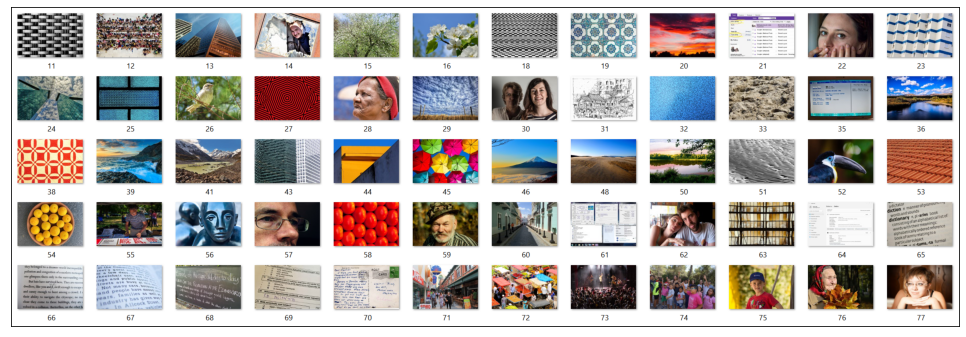

In [11]:
exibe_imagem_grande(Image.open(DIR+'img_dataset.png'),'')
display(interface)